### 1. Introduction to Spatial Correlation:

Spatial correlation is a measure of how two or more points in a dataset are related over a space. In images, for instance, spatial correlation might tell us about the similarity of pixel values at different locations. One way to measure this is with the correlation function, which gives us a measure of similarity as a function of distance or lag.

The spatial correlation function \( C(r) \) is defined as:

$$
C(r) = \langle f(\mathbf{x}) f(\mathbf{x} + \mathbf{r}) \rangle
$$

where $ f(\mathbf{x}) $ is the value of the function (e.g., pixel intensity) at position $ \mathbf{x} $, and the angle brackets denote an average over all positions $ \mathbf{x} $.

### 2. Fourier Transforms:

The Fourier transform is a mathematical operation that transforms a function (often a time-domain function) into its frequency components. It is a powerful tool for analyzing patterns, and in the context of spatial correlations, it allows us to work in the frequency domain rather than the spatial domain.

The 2D Fourier transform of a function $ f(\mathbf{x}) $ is given by:

$$
F(\mathbf{k}) = \int f(\mathbf{x}) e^{-i\mathbf{k}\cdot\mathbf{x}} d\mathbf{x}
$$

where $F(\mathbf{k})$ is the Fourier transform of $ f(\mathbf{x}) $, and $ \mathbf{k} $ is the wave vector in the frequency domain.

### 3. Wiener-Khinchin Theorem:

The Wiener-Khinchin theorem is key to our discussion. It states that the Fourier transform of the autocorrelation function of a signal is equal to the power spectral density of that signal.

Mathematically:

$$
C(r) \xrightarrow{FT} |F(k)|^2
$$

This means that if you compute the Fourier transform of your data, and then square its magnitude, you get the Fourier transform of the spatial correlation function. This is useful because working in the frequency domain can be more computationally efficient and can reveal patterns not immediately obvious in the spatial domain.


Given a 2D dataset (like an image), here's the procedure to compute its spatial correlation function using Fourier transforms:

1. Compute the 2D Fourier transform of the dataset.
2. Compute the magnitude squared of the result (this gives the power spectrum).
3. Compute the inverse 2D Fourier transform of the power spectrum. This will yield the spatial correlation function.

### 4. Extracting Correlation Length:

For an exponential decay in the spatial correlation function:

$$
C(r) = C_0 \exp\left(-\frac{r}{\xi}\right)
$$

The correlation length, \( \xi \), is the distance at which the correlation function drops to \( \frac{C_0}{e} \), or approximately \(37\%\) of its initial value.

To extract the correlation length:

1. Fit the computed spatial correlation function to the exponential form.
2. Extract the parameter \( \xi \) from the fit. This will be your correlation length.


In [1]:
import os
import glob
import sys
sys.path.append('../../activedrops')

import autocorrelation
import pivdrops
import viz
viz.set_plotting_style()

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [2]:
def load_and_convert_data(file_path):
    """
    Load data from a specified file path and convert units.
    
    Parameters:
    - file_path (str): Path to the data file.
    
    Returns:
    - DataFrame: Processed data with columns 'x [um]', 'y [um]', 'u [um/s]', and 'v [um/s]'.
    """
    
    # Load the data
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity units
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Retain only the converted columns
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df


def compute_full_product(data):
    """
    Compute the full product of the Fourier transform of data with its complex conjugate.
    
    Parameters:
    - data (ndarray): 2D array containing velocity magnitudes or other spatial data.
    
    Returns:
    - ndarray: Product of the Fourier transform of data with its complex conjugate.
    """
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    """
    Compute the direct spatial autocorrelation from the full product of Fourier transforms.
    
    Parameters:
    - full_product (ndarray): Product of the Fourier transform of data with its complex conjugate.
    - shape (tuple): Shape of the original data array.
    - r (int): Spatial lag value for which autocorrelation should be computed.
    
    Returns:
    - float: Spatial autocorrelation value for the specified spatial lag r.
    """
    inverse = np.real(np.fft.ifft2(full_product))
    
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

# Define the exponential decay function
def exponential_decay(r, A, xi, C):
    return A * np.exp(-r / xi) + C


def compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values):
    """
    Compute the normalized spatial autocorrelation for a single frame.
    
    Parameters:
    - tt (int): Frame number.
    - UX, UY (ndarray): 2D arrays representing the x and y components of velocity, respectively.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - tuple: Frame number and the list of normalized computed autocorrelation values for specified r_values.
    """
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    
    # Normalize the results by the autocorrelation value at r=0
    R_0 = results[0]
    normalized_results = [r / R_0 for r in results]
    normalized_results = normalized_results
    return tt, normalized_results 

# Now, we recompute the autocorrelation using the normalized function
def compute_autocorrelation_for_frames(file_paths, r_values):
    """
    Compute normalized spatial autocorrelation for multiple frames.
    
    Parameters:
    - file_paths (list): List of file paths for each frame.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - dict: Dictionary with keys as frame number and values as computed normalized autocorrelation.
    """
    results = {}
    
    for file_path in file_paths:
        # Load and convert data
        df = load_and_convert_data(file_path)
        
        # Reshape velocities for processing
        reshape_dim = int(np.sqrt(df.shape[0]))
        UX, UY = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))
        
        # Compute normalized autocorrelation for the frame
        frame_num = int(file_path.split('_')[-1].split('.')[0])
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(frame_num, UX, UY, r_values)
        
        results[frame_num] = autocorr_values 
        
    return results 


input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))
r_values_custom = list(range(1, 50))
results_multiple_frames = compute_autocorrelation_for_frames(file_paths[:5], r_values_custom)
results_multiple_frames

{1: [1.0,
  0.9069994084397637,
  0.8550055428870106,
  0.8201759027940786,
  0.8071944806968082,
  0.7829013438521111,
  0.758932397077223,
  0.7359330547549408,
  0.7014068876448413,
  0.6794493903951092,
  0.6633030546467688,
  0.6430614904906359,
  0.6391166028608074,
  0.6105814984560864,
  0.5786393907722107,
  0.5738759602698046,
  0.5584700460749206,
  0.5532031140151474,
  0.5379846633492669,
  0.5270018015711712,
  0.5221875645204809,
  0.4998981703587978,
  0.49543285912249374,
  0.4895592218312715,
  0.4817353525820428,
  0.4693544781463695,
  0.4558332179486414,
  0.4503344962243953,
  0.4325823825436186,
  0.42544513111064935,
  0.42516520458458273,
  0.41641032473276074,
  0.41107344191360523,
  0.4024686663871987,
  0.39319604311460893,
  0.3773234807287769,
  0.35950721393033097,
  0.3526515383750017,
  0.3458903819428188,
  0.34156642653156105,
  0.3375201109546384,
  0.32168413161111475,
  0.320563294290648,
  0.31167098057060577,
  0.3105878910094706,
  0.3024940851

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_velocity_autocorrelation(UX, UY):
    """
    Visualize the 2D velocity autocorrelation using the Fourier method for the velocity magnitude component.

    Parameters:
    - UX, UY (ndarray): 2D arrays representing the x and y components of velocity, respectively.
    
    Returns:
    - None: Displays the centered and normalized 2D autocorrelation plot.
    """
    
    # Calculate the magnitude of the velocity
    magnitude = np.sqrt(UX**2 + UY**2)
    
    # Compute the full product of the Fourier transform of data with its complex conjugate
    full_product = np.fft.fft2(magnitude) * np.conj(np.fft.fft2(magnitude))
    
    # Get the inverse Fourier transform to obtain the autocorrelation in the spatial domain
    R_magnitude_fourier = np.real(np.fft.ifft2(full_product))
    
    # Normalize the autocorrelation
    R_magnitude_fourier_normalized = R_magnitude_fourier / R_magnitude_fourier[0, 0]
    
    # Center the autocorrelation
    R_magnitude_fourier_centered = np.fft.fftshift(R_magnitude_fourier_normalized)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(R_magnitude_fourier_centered, cmap='viridis', origin='lower')
    plt.colorbar(label="Normalized Autocorrelation Value")
    plt.title("2D Velocity Autocorrelation (Fourier Method) - Velocity Magnitude Component")
    plt.xlabel("Spatial Lag in x-direction (microns)")
    plt.ylabel("Spatial Lag in y-direction (microns)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


In [4]:
input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))

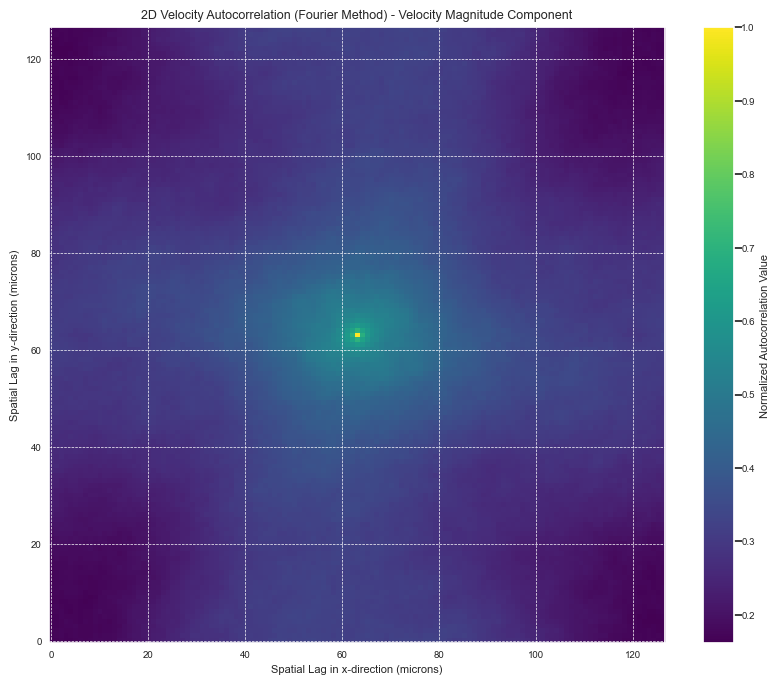

In [5]:
# Load and convert data
df = load_and_convert_data(file_paths[0])

# Reshape velocities for processing
reshape_dim = int(np.sqrt(df.shape[0]))
UX, UY = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))

# Visualize the 2D autocorrelation
plot_2d_velocity_autocorrelation(UX, UY)

In [6]:
# Define the range of r values for which autocorrelation should be computed
r_values_custom = list(range(1, 50))
# Display the function signature and docstring
results_multiple_frames = compute_autocorrelation_for_frames(file_paths, r_values_custom)


In [7]:
results_multiple_frames

{1: [1.0,
  0.9069994084397637,
  0.8550055428870106,
  0.8201759027940786,
  0.8071944806968082,
  0.7829013438521111,
  0.758932397077223,
  0.7359330547549408,
  0.7014068876448413,
  0.6794493903951092,
  0.6633030546467688,
  0.6430614904906359,
  0.6391166028608074,
  0.6105814984560864,
  0.5786393907722107,
  0.5738759602698046,
  0.5584700460749206,
  0.5532031140151474,
  0.5379846633492669,
  0.5270018015711712,
  0.5221875645204809,
  0.4998981703587978,
  0.49543285912249374,
  0.4895592218312715,
  0.4817353525820428,
  0.4693544781463695,
  0.4558332179486414,
  0.4503344962243953,
  0.4325823825436186,
  0.42544513111064935,
  0.42516520458458273,
  0.41641032473276074,
  0.41107344191360523,
  0.4024686663871987,
  0.39319604311460893,
  0.3773234807287769,
  0.35950721393033097,
  0.3526515383750017,
  0.3458903819428188,
  0.34156642653156105,
  0.3375201109546384,
  0.32168413161111475,
  0.320563294290648,
  0.31167098057060577,
  0.3105878910094706,
  0.3024940851

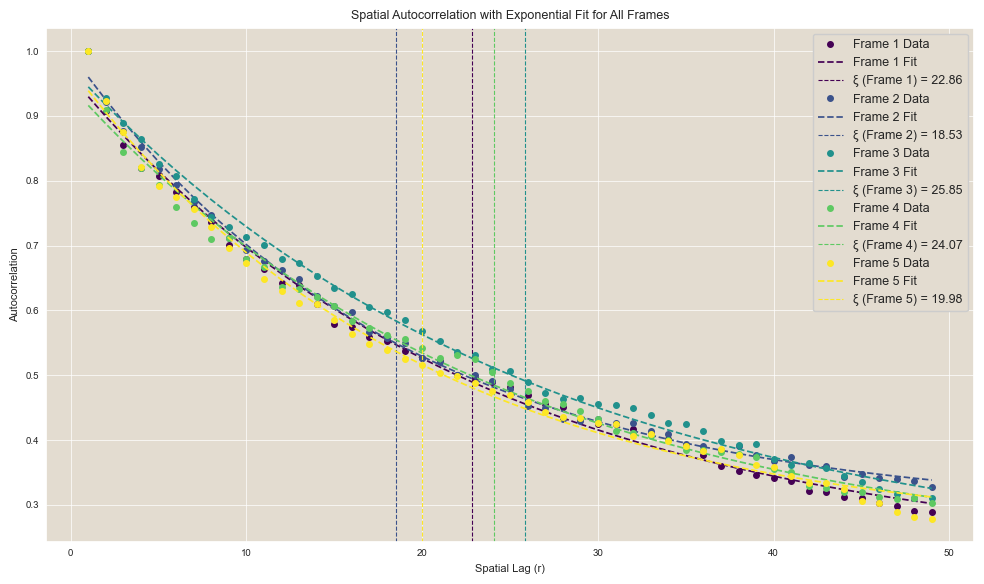

In [8]:
# Generate dynamic colors based on number of frames using a colormap
def generate_dynamic_colors(n):
    """
    Generate a list of distinct colors based on the number of frames using a colormap.
    
    Parameters:
    - n (int): Number of required colors.
    
    Returns:
    - list: List of RGBA colors.
    """
    colormap = plt.cm.viridis  # using the 'viridis' colormap, but this can be changed to any other colormap
    return [colormap(i) for i in np.linspace(0, 1, n)]

# Modify the plot_autocorrelation_with_fit function to use dynamic colors
def plot_autocorrelation_with_fit_dynamic_colors(results, r_values):
    """
    Plot spatial autocorrelation with exponential fit for provided results.
    
    Parameters:
    - results (dict): Dictionary with keys as frame number and values as computed autocorrelation.
    - r_values (list): List of spatial lags for which autocorrelation has been computed.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(10, 6))
    
    # Get dynamic colors based on the number of frames
    colors = generate_dynamic_colors(len(results))

    for idx, (frame_num, autocorr_values) in enumerate(results.items()):
        # Informed guesses for fit parameters
        A_guess = autocorr_values[0]
        C_guess = np.mean(autocorr_values[-5:])
        xi_guess = next((r for r, value in zip(r_values, autocorr_values) if value <= A_guess / 2), 20)
        
        # Fit the spatial autocorrelation data with informed guesses
        params_informed, _ = curve_fit(exponential_decay, r_values, autocorr_values, p0=[A_guess, xi_guess, C_guess])
        A_fit, xi_fit, C_fit = params_informed

        # Generate the fitted values for visualization
        fitted_values = exponential_decay(np.array(r_values), A_fit, xi_fit, C_fit)

        # Plot the original and fitted autocorrelation data for the frame
        plt.plot(r_values, autocorr_values , 'o', color=colors[idx], label=f"Frame {frame_num} Data", markersize=4)
        plt.plot(r_values, fitted_values, '--', color=colors[idx], label=f"Frame {frame_num} Fit")
        plt.axvline(xi_fit, color=colors[idx], linestyle='--', linewidth=0.8, label=f"ξ (Frame {frame_num}) = {xi_fit:.2f}")

    plt.xlabel('Spatial Lag (r)')
    plt.ylabel('Autocorrelation')
    plt.title('Spatial Autocorrelation with Exponential Fit for All Frames')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Return the function to check if there are any errors
plot_autocorrelation_with_fit_dynamic_colors(dict(list(results_multiple_frames.items())[0:5]), r_values_custom)


In [9]:
def get_correlation_length_dataframe(file_paths, results, r_values):
    """
    Process autocorrelation data, fit exponential decay, and return a DataFrame with correlation lengths.
    
    Parameters:
    - file_paths (list): List of file paths for each frame.
    - results (dict): Dictionary with keys as frame number and values as computed autocorrelation.
    - r_values (list): List of spatial lags for which autocorrelation has been computed.
    
    Returns:
    - DataFrame: DataFrame with columns for time (in minutes), file name, and correlation length.
    """
    
    correlation_lengths = []
    
    for file_path, (frame_num, autocorr_values) in zip(file_paths, results.items()):
        # Informed guesses for fit parameters
        A_guess = autocorr_values[0]
        C_guess = np.mean(autocorr_values[-5:])
        xi_guess = next((r for r, value in zip(r_values, autocorr_values) if value <= A_guess / 2), 20)
        
        # Fit the spatial autocorrelation data with informed guesses
        params_informed, _ = curve_fit(exponential_decay, r_values, autocorr_values, p0=[A_guess, xi_guess, C_guess])
        _, xi_fit, _ = params_informed
        
        if xi_fit <= 500:
            correlation_lengths.append([frame_num * 3 / 60, file_path.split('/')[-1], xi_fit])
        
    return pd.DataFrame(correlation_lengths, columns=['Time (min)', 'File Name', 'Correlation Length'])


# Test the function with the previous file paths and results
# Note: We'll re-run the compute_autocorrelation_for_frames function to get the results for this test
results_multiple_frames = compute_autocorrelation_for_frames(file_paths, r_values_custom)
df_correlation_length = get_correlation_length_dataframe(file_paths, results_multiple_frames, r_values_custom)
df_correlation_length


,Time (min),File Name,Correlation Length
0,0.05,k401bio-250nM-piv\PIVlab_0001.txt,22.860318
1,0.10,k401bio-250nM-piv\PIVlab_0002.txt,18.528855
2,0.15,k401bio-250nM-piv\PIVlab_0003.txt,25.848133
3,0.20,k401bio-250nM-piv\PIVlab_0004.txt,24.072502
4,0.25,k401bio-250nM-piv\PIVlab_0005.txt,19.978693
...,...,...,...
2791,141.60,k401bio-250nM-piv\PIVlab_2832.txt,35.058872
2792,141.65,k401bio-250nM-piv\PIVlab_2833.txt,40.183008
2793,141.70,k401bio-250nM-piv\PIVlab_2834.txt,31.994680
2794,141.75,k401bio-250nM-piv\PIVlab_2835.txt,32.994029


In [10]:
df_correlation_length["Correlation Length"] = df_correlation_length["Correlation Length"] / 11.75

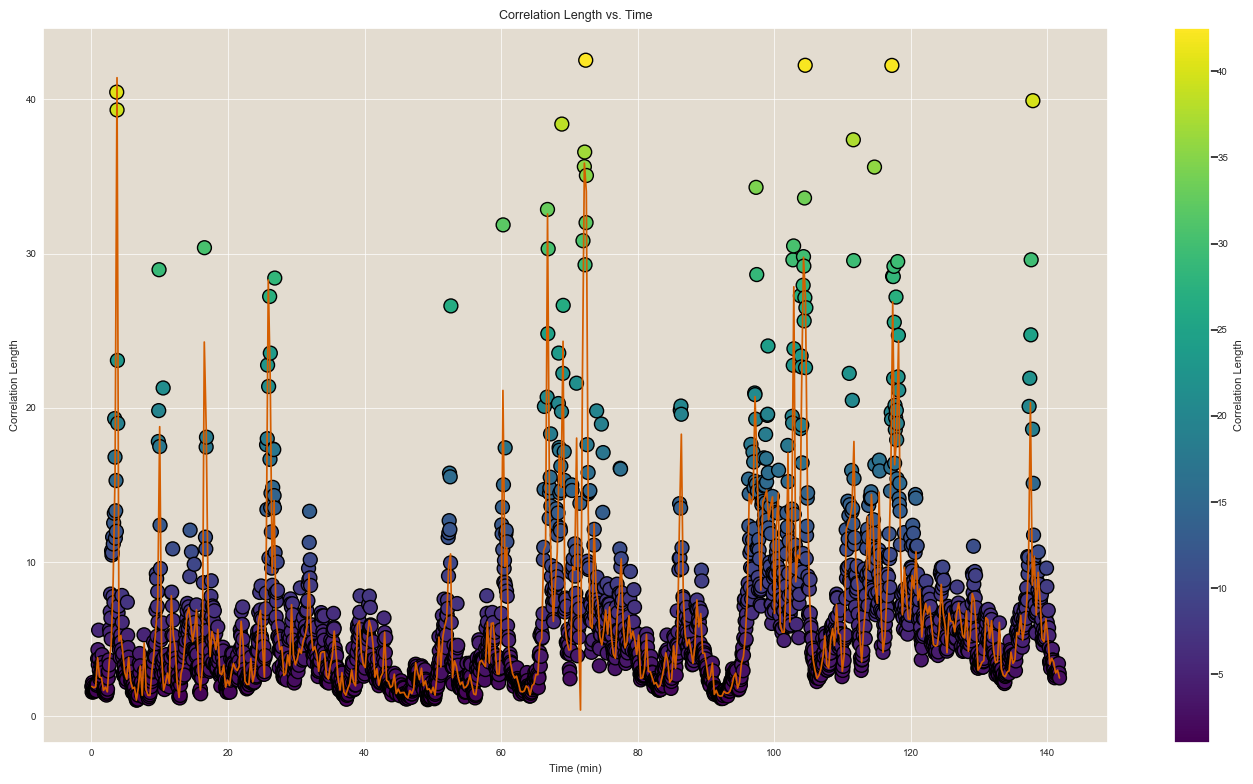

In [11]:
from scipy.interpolate import CubicSpline

def plot_correlation_length_vs_time(df_correlation_length, filename=None):
    """
    Plot correlation length against time using provided DataFrame, color the y-values with a heatmap in viridis,
    and connect the points with an interpolated line.
    
    Parameters:
    - df_correlation_length (DataFrame): DataFrame with columns for time (in minutes) and correlation length.
    
    Returns:
    - None: Displays the plot.
    """
    
    plt.figure(figsize=(14, 8))
    
    # Use scatter for heatmap coloring
    plt.scatter(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'], 
                c=df_correlation_length['Correlation Length'], cmap='viridis', s=100, edgecolors='black')
    
    # Interpolate using cubic spline
    cs = CubicSpline(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'])
    times = np.linspace(df_correlation_length['Time (min)'].min(), df_correlation_length['Time (min)'].max(), 500)
    plt.plot(times, cs(times), 'r-')
    
    # Optional: Add a colorbar to indicate the correlation length values
    plt.colorbar(label='Correlation Length')
    
    plt.xlabel('Time (min)')
    plt.ylabel('Correlation Length')
    plt.title('Correlation Length vs. Time')
    # plt.legend()
    plt.grid(True)
    plt.tight_layout()
        
    if filename:
        plt.savefig(filename, format='jpg', dpi=200)
    else:
        plt.show()
  

# Test the function with the df_correlation_length DataFrame
plot_correlation_length_vs_time(df_correlation_length, "../../data/k401bio-250nM-piv/plots/Rvstime.jpg")



In [12]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar
from bokeh.layouts import column
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from scipy.interpolate import CubicSpline

def plot_correlation_length_vs_time(df_correlation_length):
    """
    Plot correlation length against time using provided DataFrame with Bokeh, color the y-values with a heatmap in viridis,
    and connect the points with an interpolated line. Tooltips display the correlation length on hover.
    
    Parameters:
    - df_correlation_length (DataFrame): DataFrame with columns for time (in minutes) and correlation length.
    
    Returns:
    - None: Displays the interactive plot.
    """
    
    # Interpolate using cubic spline
    cs = CubicSpline(df_correlation_length['Time (min)'], df_correlation_length['Correlation Length'])
    times = np.linspace(df_correlation_length['Time (min)'].min(), df_correlation_length['Time (min)'].max(), 500)
    
    # Set up the Bokeh plot
    p = figure(width=800, height=400, title='Correlation Length vs. Time with Interpolation',
               x_axis_label='Time (min)', y_axis_label='Correlation Length', tools='')
    
    # Add the data points with hover info
    mapper = linear_cmap(field_name='Correlation Length', palette=Viridis256, 
                         low=min(df_correlation_length['Correlation Length']), 
                         high=max(df_correlation_length['Correlation Length']))
    
    source = ColumnDataSource(df_correlation_length)
    p.scatter(x='Time (min)', y='Correlation Length', source=source, size=10, color=mapper, 
              legend_label='Data Points', alpha=1)  # Added alpha for transparency
    
    # Add the interpolated line (after scatter to ensure it's on top)
    p.line(times, cs(times), line_color='orange', line_width=2)
    
    # Add hover tool
    hover = HoverTool()
    hover.tooltips = [("Correlation Length", "@{Correlation Length}"), ("File Name", "@{File Name}")]
    p.add_tools(hover)
    
    # Color bar
    color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0))
    p.add_layout(color_bar, 'right')
    
    output_notebook()
    show(p)

# Test the modified function with the df_correlation_length DataFrame
plot_correlation_length_vs_time(df_correlation_length)


Loading BokehJS ...

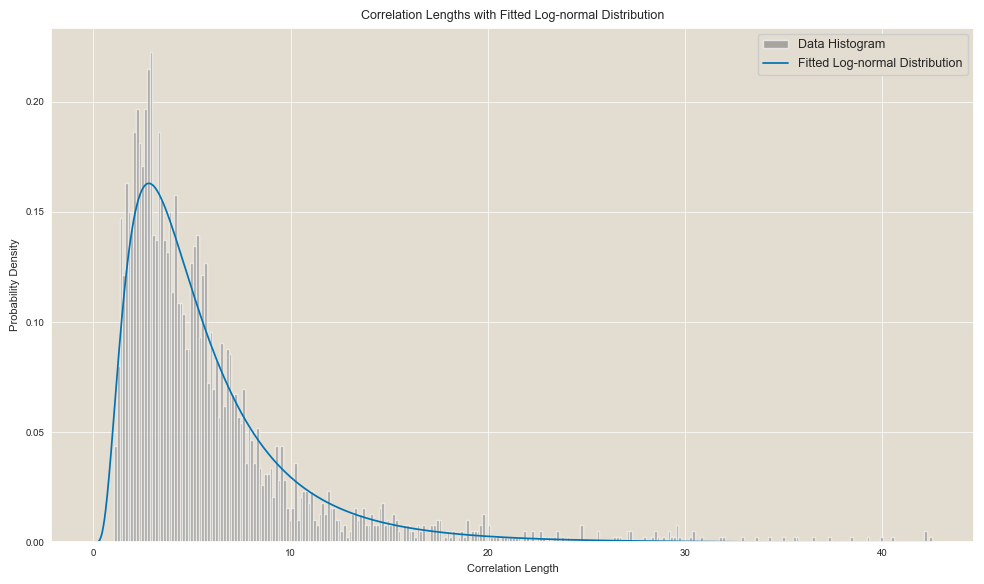

In [13]:
from scipy.stats import lognorm

# Fit the data to a log-normal distribution
shape, loc, scale = lognorm.fit(df_correlation_length['Correlation Length'], floc=0)

# Generate x values for plotting
x_values_lognorm = np.linspace(0, df_correlation_length['Correlation Length'].max(), len(df_correlation_length['Correlation Length']))
y_values_lognorm = lognorm.pdf(x_values_lognorm, shape, loc, scale)

# Plot the histogram of the correlation lengths and the fitted log-normal distribution
plt.figure(figsize=(10, 6))
plt.hist(df_correlation_length['Correlation Length'], bins=300, density=True, alpha=0.6, color='gray', label='Data Histogram')
plt.plot(x_values_lognorm, y_values_lognorm, 'b-', label='Fitted Log-normal Distribution')
plt.title('Correlation Lengths with Fitted Log-normal Distribution')
plt.xlabel('Correlation Length')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../../data/k401bio-250nM-piv/plots/Rvstime-pdf.jpg", format='jpg', dpi=200)
plt.show()



In [14]:
def load_and_convert_data(file_path):
    """
    Load data from a specified file path and convert units.
    
    Parameters:
    - file_path (str): Path to the data file.
    
    Returns:
    - DataFrame: Processed data with columns 'x [um]', 'y [um]', 'u [um/s]', and 'v [um/s]'.
    """
    
    # Load the data
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity units
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Replace NaN values with 0s
    df = df.fillna(0)
    
    # Retain only the converted columns
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df


def compute_full_product(data):
    """
    Compute the full product of the Fourier transform of data with its complex conjugate.
    
    Parameters:
    - data (ndarray): 2D array containing velocity magnitudes or other spatial data.
    
    Returns:
    - ndarray: Product of the Fourier transform of data with its complex conjugate.
    """
    return np.fft.fft2(data) * np.conj(np.fft.fft2(data))

def direct_spatial_autocorrelation_from_full_product(full_product, shape, r):
    """
    Compute the direct spatial autocorrelation from the full product of Fourier transforms.
    
    Parameters:
    - full_product (ndarray): Product of the Fourier transform of data with its complex conjugate.
    - shape (tuple): Shape of the original data array.
    - r (int): Spatial lag value for which autocorrelation should be computed.
    
    Returns:
    - float: Spatial autocorrelation value for the specified spatial lag r.
    """
    inverse = np.real(np.fft.ifft2(full_product))
    
    return (inverse[r, r] + inverse[-r, -r]) / (shape[0] * shape[1])

# Define the exponential decay function
def exponential_decay(r, A, xi, C):
    return A * np.exp(-r / xi) + C


def compute_autocorrelation_for_one_time_simple(tt, UX, UY, r_values):
    """
    Compute the normalized spatial autocorrelation for a single frame.
    
    Parameters:
    - tt (int): Frame number.
    - UX, UY (ndarray): 2D arrays representing the x and y components of velocity, respectively.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - tuple: Frame number and the list of normalized computed autocorrelation values for specified r_values.
    """
    magnitude = np.sqrt(UX**2 + UY**2)
    full_product = compute_full_product(magnitude)
    results = [direct_spatial_autocorrelation_from_full_product(full_product, magnitude.shape, r) for r in r_values]
    
    # Normalize the results by the autocorrelation value at r=0
    R_0 = results[0]
    normalized_results = [r / R_0 for r in results]
    
    return tt, normalized_results

# Now, we recompute the autocorrelation using the normalized function
def compute_autocorrelation_for_frames(file_paths, r_values):
    """
    Compute normalized spatial autocorrelation for multiple frames.
    
    Parameters:
    - file_paths (list): List of file paths for each frame.
    - r_values (list): List of spatial lags for which autocorrelation should be computed.
    
    Returns:
    - dict: Dictionary with keys as frame number and values as computed normalized autocorrelation.
    """
    results = {}
    
    for file_path in file_paths:
        # Load and convert data
        df = load_and_convert_data(file_path)
        
        # Reshape velocities for processing
        reshape_dim = int(np.sqrt(df.shape[0]))
        UX, UY = df['u [um/s]'].values.reshape((reshape_dim, reshape_dim)), df['v [um/s]'].values.reshape((reshape_dim, reshape_dim))
        
        # Compute normalized autocorrelation for the frame
        frame_num = int(file_path.split('_')[-1].split('.')[0])
        _, autocorr_values = compute_autocorrelation_for_one_time_simple(frame_num, UX, UY, r_values)
        
        results[frame_num] = autocorr_values
        
    return results


input_dir = "../../data/k401bio-250nM-piv/"
input_pattern = os.path.join(input_dir, 'PIVlab_*.txt')
file_paths = sorted(glob.glob(input_pattern))
r_values_custom = list(range(1, 50))
results_multiple_frames = compute_autocorrelation_for_frames(file_paths[:1], r_values_custom)
results_multiple_frames


{1: [1.0,
  0.9069994084397637,
  0.8550055428870106,
  0.8201759027940786,
  0.8071944806968082,
  0.7829013438521111,
  0.758932397077223,
  0.7359330547549408,
  0.7014068876448413,
  0.6794493903951092,
  0.6633030546467688,
  0.6430614904906359,
  0.6391166028608074,
  0.6105814984560864,
  0.5786393907722107,
  0.5738759602698046,
  0.5584700460749206,
  0.5532031140151474,
  0.5379846633492669,
  0.5270018015711712,
  0.5221875645204809,
  0.4998981703587978,
  0.49543285912249374,
  0.4895592218312715,
  0.4817353525820428,
  0.4693544781463695,
  0.4558332179486414,
  0.4503344962243953,
  0.4325823825436186,
  0.42544513111064935,
  0.42516520458458273,
  0.41641032473276074,
  0.41107344191360523,
  0.4024686663871987,
  0.39319604311460893,
  0.3773234807287769,
  0.35950721393033097,
  0.3526515383750017,
  0.3458903819428188,
  0.34156642653156105,
  0.3375201109546384,
  0.32168413161111475,
  0.320563294290648,
  0.31167098057060577,
  0.3105878910094706,
  0.3024940851